In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0

In [ ]:
!pip install arxiv wikipedia google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=7c75ce939b66fb1c00df40c242488c884b974751357a53cabbf8b0fdaf88da85
  Stored in directory: /root/.cache/pip/wheels/d3/b2/c3/03302d12bb44a2cdff3c9371f31b72c0c4e84b8d2285eeac53
Successfully built google-search-results


In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

In [38]:
# working with tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper, GoogleSerperAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun, GoogleSerperRun
from google.colab import userdata
import os
from dotenv import load_dotenv
load_dotenv()

serp_api_key = userdata.get("SERPAPI_KEY")

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=400)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=400)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

# SerpAPI Google Search wrapper
serpapi = GoogleSerperAPIWrapper(serper_api_key=serp_api_key)
serp_tool = GoogleSerperRun(api_wrapper=serpapi)

# Example search using Google Search tool
# google_results = serp_tool.invoke("Give me 5 flowers name")
# print(google_results)

In [ ]:
wiki_tool.invoke("What is the capital of germany?")

'Page: Capital punishment in Germany\nSummary: Capital punishment in Germany has been abolished for all crimes, and is now explicitly prohibited by the constitution. It was abolished in West Germany in 1949, in the Saarland in 1956 (as part of the Saarland joining West Germany and becoming a state of West Germany), and East Germany in 1987. The last person executed in Germany was the East German Wer'

In [ ]:
arxiv_tool.invoke("NeRF")

'Published: 2023-04-26\nTitle: Super-NeRF: View-consistent Detail Generation for NeRF super-resolution\nAuthors: Yuqi Han, Tao Yu, Xiaohang Yu, Yuwang Wang, Qionghai Dai\nSummary: The neural radiance field (NeRF) achieved remarkable success in modeling 3D\nscenes and synthesizing high-fidelity novel views. However, existing NeRF-based\nmethods focus more on the make full use of the image resolution to g'

In [39]:
tools = [wiki_tool, arxiv_tool, serp_tool]

In [40]:
# Langgraph application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list, add_messages]


In [41]:
from langgraph.graph import StateGraph, START, END


In [42]:
graph_builder = StateGraph(State)

In [43]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_api_key = userdata.get("GROQ_API_KEY")
llm = ChatGroq(
    groq_api_key= groq_api_key,
    model_name = "llama-3.2-90b-text-preview"
)

In [44]:
llm_with_tools = llm.bind_tools(tools=tools)

In [45]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}



In [46]:
from langgraph.prebuilt import ToolNode, tools_condition

In [47]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)



In [48]:
graph = graph_builder.compile()

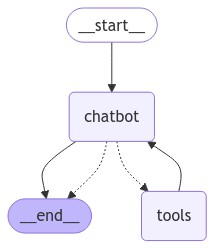

In [49]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [63]:
user_input = "hey there, do you know crocodile loves cat?"
events = graph.stream(
    {"messages":[("user", user_input)]}, stream_mode="values"
)
for e in events:
  e["messages"][-1].pretty_print()

================================ Human Message =================================

hey there, do you know crocodile loves cat?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_an93)
 Call ID: call_an93
  Args:
    query: crocodile cat relationship
================================= Tool Message =================================
Name: wikipedia

Page: Nile crocodile
Summary: The Nile crocodile (Crocodylus niloticus) is a large crocodilian native to freshwater habitats in Africa, where it is present in 26 countries. It is widely distributed in sub-Saharan Africa, occurring mostly in the eastern, southern, and central regions of the continent, and lives in different types of aquatic environments such as lakes, rivers, swamps and marshlands.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_qvmq)
 Call ID: call_qvmq
  Args:
    query: do crocodiles get along with cats
==